## Importación de librerías

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from pathlib import Path
import cv2
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

## Configuración de rutas

In [2]:
ruta_base = Path(r'e:\06. Sexto Ciclo\01. Machine Learning\07. Workspace\16S03. Proyecto 03\P3-EcoSort')
ruta_train = ruta_base / 'data' / 'preprocessed' / 'train'
ruta_val = ruta_base / 'data' / 'preprocessed' / 'val'
ruta_figuras = ruta_base / 'result' / 'figures'

clases = ['general', 'paper', 'plastic']

## 1. Análisis de estructura del dataset

### 1.1 Conteo de imágenes por clase

In [3]:
def contar_imagenes_por_clase(ruta_dataset, nombre_split):
    conteo = {}
    for clase in clases:
        ruta_clase = ruta_dataset / clase
        archivos = [f for f in ruta_clase.glob('*') if f.suffix.lower() in ['.jpg', '.jpeg', '.png']]
        conteo[clase] = len(archivos)
    return pd.DataFrame(list(conteo.items()), columns=['Clase', nombre_split])

df_train = contar_imagenes_por_clase(ruta_train, 'Train')
df_val = contar_imagenes_por_clase(ruta_val, 'Val')

df_conteo = pd.merge(df_train, df_val, on='Clase')
df_conteo['Total'] = df_conteo['Train'] + df_conteo['Val']
df_conteo

,Clase,Train,Val,Total
0,general,838,210,1048
1,paper,797,200,997
2,plastic,385,97,482


### 1.2 Visualización de distribución de clases

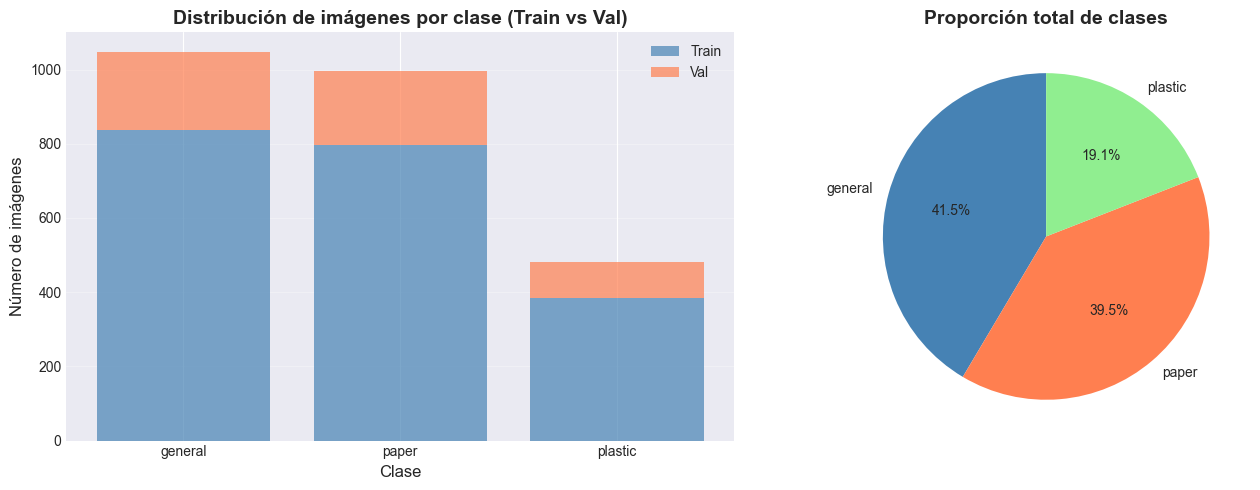

In [4]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].bar(df_conteo['Clase'], df_conteo['Train'], alpha=0.7, label='Train', color='steelblue')
axes[0].bar(df_conteo['Clase'], df_conteo['Val'], bottom=df_conteo['Train'], alpha=0.7, label='Val', color='coral')
axes[0].set_xlabel('Clase', fontsize=12)
axes[0].set_ylabel('Número de imágenes', fontsize=12)
axes[0].set_title('Distribución de imágenes por clase (Train vs Val)', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

axes[1].pie(df_conteo['Total'], labels=df_conteo['Clase'], autopct='%1.1f%%', startangle=90, colors=['steelblue', 'coral', 'lightgreen'])
axes[1].set_title('Proporción total de clases', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig(ruta_figuras / '01_eda_01_distribucion_clases.svg', format='svg', bbox_inches='tight')
plt.show()

### 1.3 Análisis de dimensiones de imágenes

In [5]:
def analizar_dimensiones(ruta_dataset):
    dimensiones = []
    for clase in clases:
        ruta_clase = ruta_dataset / clase
        archivos = list(ruta_clase.glob('*.jpg')) + list(ruta_clase.glob('*.jpeg')) + list(ruta_clase.glob('*.png'))
        for archivo in archivos[:100]:
            try:
                img = Image.open(archivo)
                dimensiones.append({
                    'Clase': clase,
                    'Ancho': img.width,
                    'Alto': img.height,
                    'Canales': len(img.getbands()),
                    'Formato': img.format
                })
            except Exception as e:
                continue
    return pd.DataFrame(dimensiones)

df_dim_train = analizar_dimensiones(ruta_train)
df_dim_train['Dataset'] = 'Train'
df_dim_val = analizar_dimensiones(ruta_val)
df_dim_val['Dataset'] = 'Val'

df_dimensiones = pd.concat([df_dim_train, df_dim_val], ignore_index=True)

In [6]:
estadisticas_dim = df_dimensiones.groupby('Clase').agg({
    'Ancho': ['mean', 'std', 'min', 'max'],
    'Alto': ['mean', 'std', 'min', 'max']
}).round(2)
estadisticas_dim

Ancho                  Alto               
          mean  std  min  max   mean  std  min  max
Clase                                              
general  512.0  0.0  512  512  384.0  0.0  384  384
paper    512.0  0.0  512  512  384.0  0.0  384  384
plastic  512.0  0.0  512  512  384.0  0.0  384  384

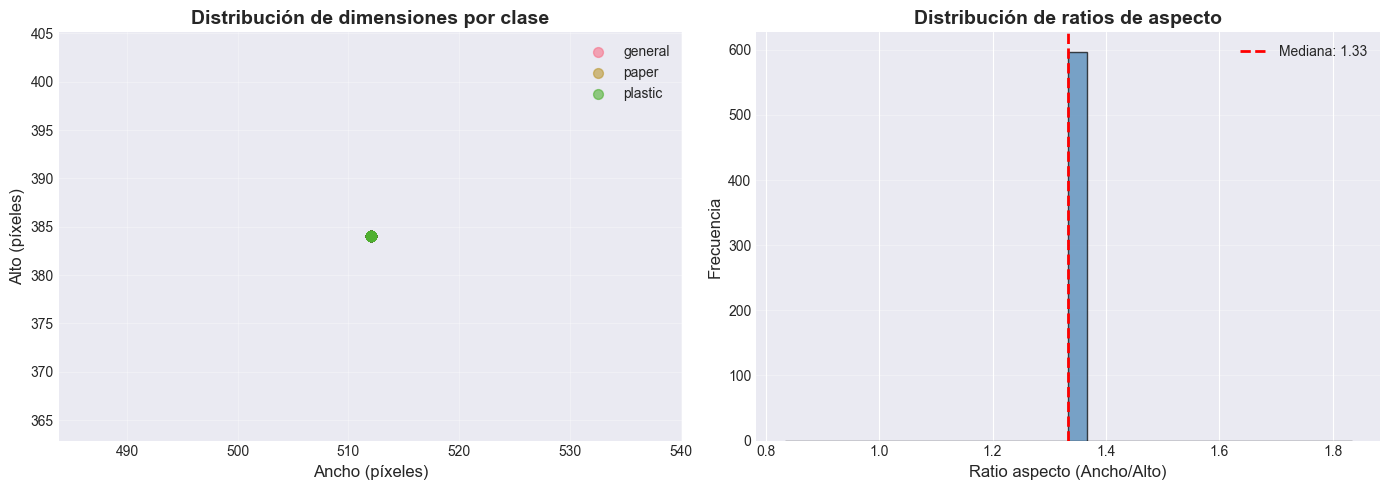

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for clase in clases:
    datos_clase = df_dimensiones[df_dimensiones['Clase'] == clase]
    axes[0].scatter(datos_clase['Ancho'], datos_clase['Alto'], alpha=0.6, label=clase, s=50)

axes[0].set_xlabel('Ancho (píxeles)', fontsize=12)
axes[0].set_ylabel('Alto (píxeles)', fontsize=12)
axes[0].set_title('Distribución de dimensiones por clase', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

aspectos = df_dimensiones['Ancho'] / df_dimensiones['Alto']
axes[1].hist(aspectos, bins=30, alpha=0.7, color='steelblue', edgecolor='black')
axes[1].set_xlabel('Ratio aspecto (Ancho/Alto)', fontsize=12)
axes[1].set_ylabel('Frecuencia', fontsize=12)
axes[1].set_title('Distribución de ratios de aspecto', fontsize=14, fontweight='bold')
axes[1].axvline(aspectos.median(), color='red', linestyle='--', linewidth=2, label=f'Mediana: {aspectos.median():.2f}')
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(ruta_figuras / '01_eda_02_analisis_dimensiones.svg', format='svg', bbox_inches='tight')
plt.show()

## 2. Visualización exploratoria

### 2.1 Ejemplos representativos de cada clase

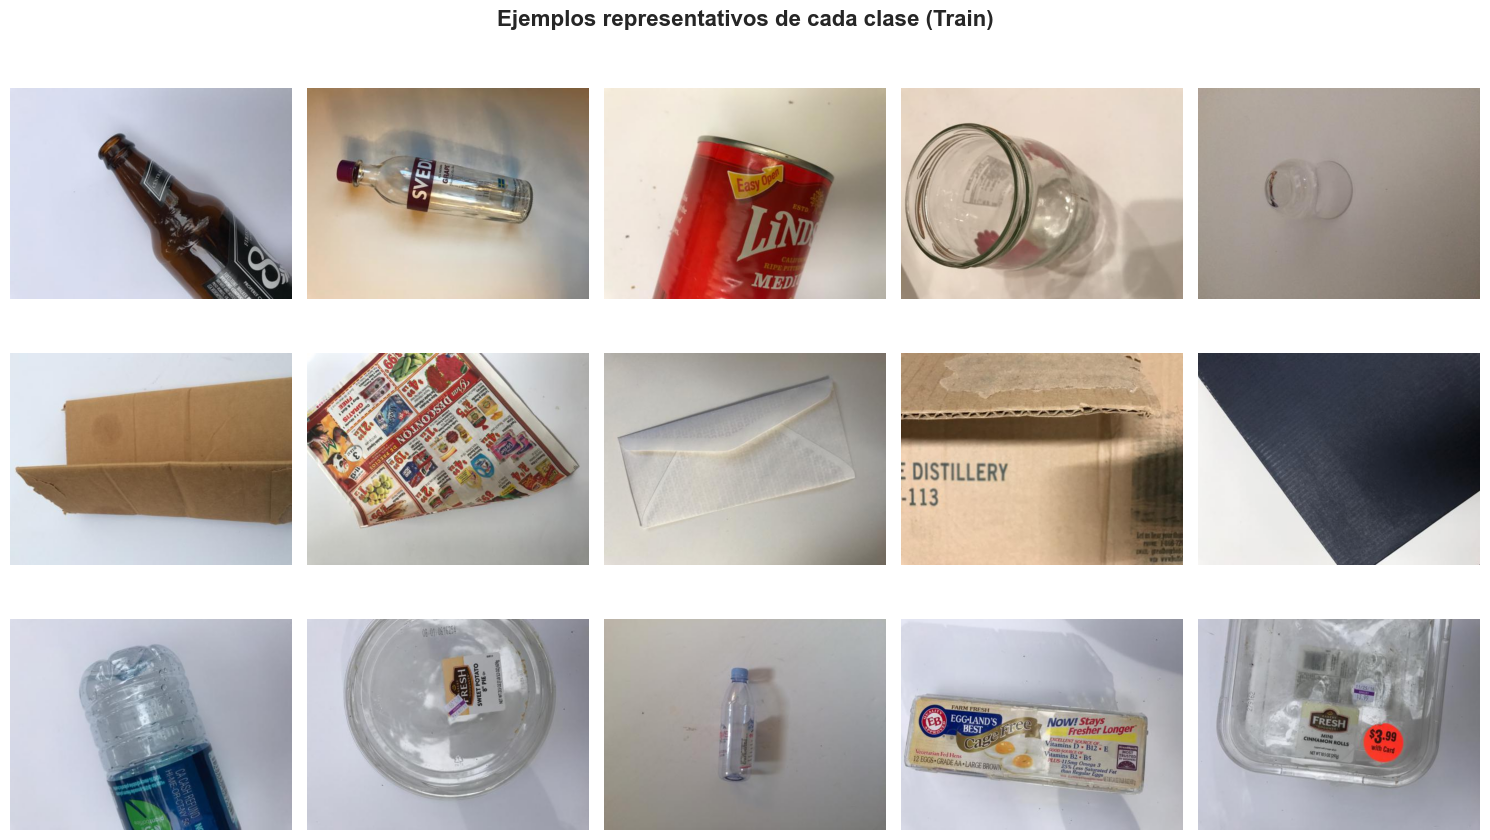

In [8]:
def mostrar_ejemplos(ruta_dataset, num_ejemplos=5):
    fig, axes = plt.subplots(len(clases), num_ejemplos, figsize=(15, 9))
    
    for i, clase in enumerate(clases):
        ruta_clase = ruta_dataset / clase
        archivos = list(ruta_clase.glob('*.jpg')) + list(ruta_clase.glob('*.jpeg')) + list(ruta_clase.glob('*.png'))
        archivos_seleccionados = np.random.choice(archivos, min(num_ejemplos, len(archivos)), replace=False)
        
        for j, archivo in enumerate(archivos_seleccionados):
            img = Image.open(archivo)
            axes[i, j].imshow(img)
            axes[i, j].axis('off')
            if j == 0:
                axes[i, j].set_ylabel(clase.upper(), fontsize=12, fontweight='bold', rotation=90, labelpad=10)
    
    plt.suptitle('Ejemplos representativos de cada clase (Train)', fontsize=16, fontweight='bold', y=0.98)
    plt.tight_layout()
    plt.savefig(ruta_figuras / '01_eda_03_ejemplos_clases.svg', format='svg', bbox_inches='tight')
    plt.show()

mostrar_ejemplos(ruta_train, num_ejemplos=5)

### 2.2 Análisis de variabilidad de color

In [9]:
def analizar_estadisticas_color(ruta_dataset, num_muestras=100):
    estadisticas = []
    
    for clase in clases:
        ruta_clase = ruta_dataset / clase
        archivos = list(ruta_clase.glob('*.jpg')) + list(ruta_clase.glob('*.jpeg')) + list(ruta_clase.glob('*.png'))
        archivos_muestra = np.random.choice(archivos, min(num_muestras, len(archivos)), replace=False)
        
        for archivo in archivos_muestra:
            try:
                img = cv2.imread(str(archivo))
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                
                estadisticas.append({
                    'Clase': clase,
                    'Media_R': np.mean(img[:, :, 0]),
                    'Media_G': np.mean(img[:, :, 1]),
                    'Media_B': np.mean(img[:, :, 2]),
                    'Std_R': np.std(img[:, :, 0]),
                    'Std_G': np.std(img[:, :, 1]),
                    'Std_B': np.std(img[:, :, 2]),
                    'Brillo': np.mean(cv2.cvtColor(img, cv2.COLOR_RGB2GRAY))
                })
            except Exception as e:
                continue
    
    return pd.DataFrame(estadisticas)

df_color = analizar_estadisticas_color(ruta_train, num_muestras=100)

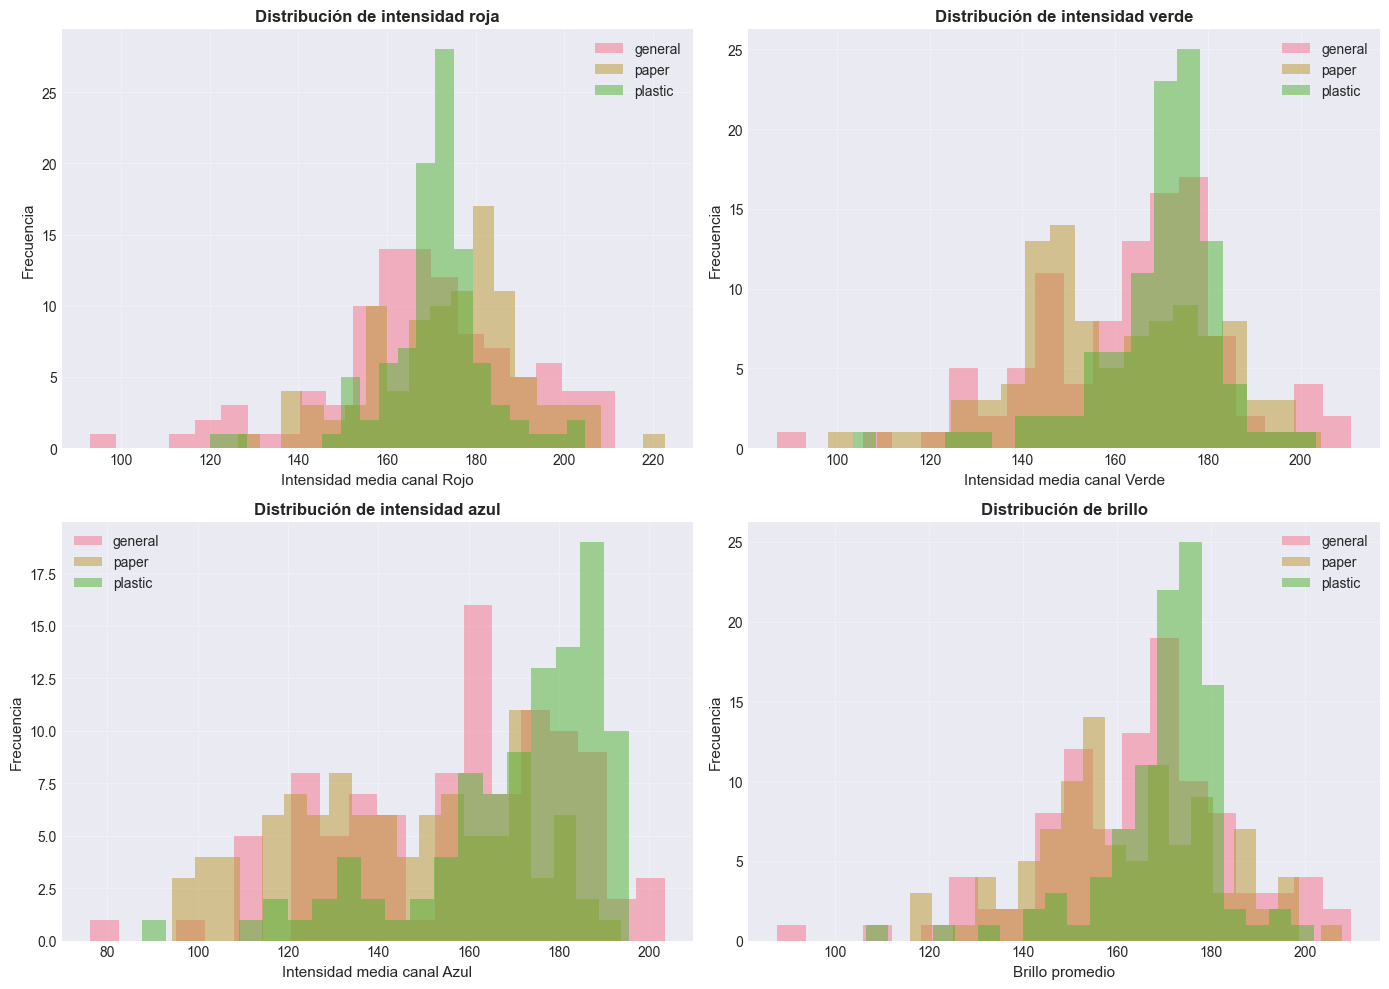

In [10]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

for clase in clases:
    datos_clase = df_color[df_color['Clase'] == clase]
    axes[0, 0].hist(datos_clase['Media_R'], alpha=0.5, label=clase, bins=20)
axes[0, 0].set_xlabel('Intensidad media canal Rojo', fontsize=11)
axes[0, 0].set_ylabel('Frecuencia', fontsize=11)
axes[0, 0].set_title('Distribución de intensidad roja', fontsize=12, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

for clase in clases:
    datos_clase = df_color[df_color['Clase'] == clase]
    axes[0, 1].hist(datos_clase['Media_G'], alpha=0.5, label=clase, bins=20)
axes[0, 1].set_xlabel('Intensidad media canal Verde', fontsize=11)
axes[0, 1].set_ylabel('Frecuencia', fontsize=11)
axes[0, 1].set_title('Distribución de intensidad verde', fontsize=12, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

for clase in clases:
    datos_clase = df_color[df_color['Clase'] == clase]
    axes[1, 0].hist(datos_clase['Media_B'], alpha=0.5, label=clase, bins=20)
axes[1, 0].set_xlabel('Intensidad media canal Azul', fontsize=11)
axes[1, 0].set_ylabel('Frecuencia', fontsize=11)
axes[1, 0].set_title('Distribución de intensidad azul', fontsize=12, fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

for clase in clases:
    datos_clase = df_color[df_color['Clase'] == clase]
    axes[1, 1].hist(datos_clase['Brillo'], alpha=0.5, label=clase, bins=20)
axes[1, 1].set_xlabel('Brillo promedio', fontsize=11)
axes[1, 1].set_ylabel('Frecuencia', fontsize=11)
axes[1, 1].set_title('Distribución de brillo', fontsize=12, fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig(ruta_figuras / '01_eda_04_analisis_color.svg', format='svg', bbox_inches='tight')
plt.show()

## 3. Análisis cuantitativo de clases

### 3.1 Métricas de desbalance

In [11]:
total_train = df_conteo['Train'].sum()
df_conteo['Porcentaje_Train'] = (df_conteo['Train'] / total_train * 100).round(2)

total_val = df_conteo['Val'].sum()
df_conteo['Porcentaje_Val'] = (df_conteo['Val'] / total_val * 100).round(2)

clase_mayoritaria = df_conteo.loc[df_conteo['Train'].idxmax(), 'Clase']
clase_minoritaria = df_conteo.loc[df_conteo['Train'].idxmin(), 'Clase']
ratio_desbalance = df_conteo['Train'].max() / df_conteo['Train'].min()

df_conteo

,Clase,Train,Val,Total,Porcentaje_Train,Porcentaje_Val
0,general,838,210,1048,41.49,41.42
1,paper,797,200,997,39.46,39.45
2,plastic,385,97,482,19.06,19.13


In [12]:
metricas_desbalance = pd.DataFrame({
    'Métrica': ['Clase mayoritaria', 'Clase minoritaria', 'Ratio de desbalance', 'Total imágenes train', 'Total imágenes val'],
    'Valor': [clase_mayoritaria, clase_minoritaria, f'{ratio_desbalance:.2f}', total_train, total_val]
})
metricas_desbalance

,Métrica,Valor
0,Clase mayoritaria,general
1,Clase minoritaria,plastic
2,Ratio de desbalance,2.18
3,Total imágenes train,2020
4,Total imágenes val,507


## 4. Detección de problemas

### 4.1 Verificación de imágenes corruptas

In [13]:
def verificar_imagenes_corruptas(ruta_dataset):
    imagenes_corruptas = []
    
    for clase in clases:
        ruta_clase = ruta_dataset / clase
        archivos = list(ruta_clase.glob('*.jpg')) + list(ruta_clase.glob('*.jpeg')) + list(ruta_clase.glob('*.png'))
        
        for archivo in archivos:
            try:
                img = Image.open(archivo)
                img.verify()
            except Exception as e:
                imagenes_corruptas.append({'Archivo': str(archivo), 'Clase': clase, 'Error': str(e)})
    
    return pd.DataFrame(imagenes_corruptas)

df_corruptas_train = verificar_imagenes_corruptas(ruta_train)
df_corruptas_val = verificar_imagenes_corruptas(ruta_val)

total_corruptas = len(df_corruptas_train) + len(df_corruptas_val)

In [14]:
resumen_corruptas = pd.DataFrame({
    'Dataset': ['Train', 'Val', 'Total'],
    'Imágenes corruptas': [len(df_corruptas_train), len(df_corruptas_val), total_corruptas]
})
resumen_corruptas

,Dataset,Imágenes corruptas
0,Train,0
1,Val,0
2,Total,0


### 4.2 Análisis de formatos y canales

In [15]:
formatos_resumen = df_dimensiones.groupby(['Clase', 'Formato']).size().reset_index(name='Cantidad')
formatos_resumen

,Clase,Formato,Cantidad
0,general,JPEG,200
1,paper,JPEG,200
2,plastic,JPEG,197


In [16]:
canales_resumen = df_dimensiones.groupby(['Clase', 'Canales']).size().reset_index(name='Cantidad')
canales_resumen

,Clase,Canales,Cantidad
0,general,3,200
1,paper,3,200
2,plastic,3,197


## 5. Conclusiones del EDA

### Resumen de hallazgos principales

**Distribución de clases:**
- Se ha analizado la distribución de imágenes entre las tres clases: general, paper y plastic
- Se identificó el nivel de desbalance entre clases que debe considerarse para el entrenamiento

**Características de las imágenes:**
- Las imágenes presentan dimensiones variables que requieren normalización
- Se observa variabilidad en iluminación, colores y condiciones de captura
- Las características de color difieren entre clases, lo cual es útil para la clasificación

**Calidad del dataset:**
- Se verificó la integridad de las imágenes
- Se identificaron formatos y canales consistentes en su mayoría

**Implicaciones para Feature Engineering:**
- Necesidad de redimensionar imágenes a tamaño fijo
- Aplicar data augmentation para balancear clases y aumentar variabilidad
- Extracción de características de color es relevante para la clasificación
- HOG capturará patrones de forma y textura complementarios al color